In [52]:
import pandas as pd

In [313]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector
from sklearn.neighbors import KNeighborsClassifier



from sklearn import neighbors, metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedKFold, LeaveOneOut
from sklearn.pipeline import Pipeline

In [523]:
data_ident = pd.read_csv('Data_Identificada_Tratada.csv', sep=',')

In [524]:
data_obje = (data_ident.dtypes == 'object')
data_obje_c = [c for c in data_obje.index if data_obje[c]]
data_num = (data_ident.dtypes == 'int64') | (data_ident.dtypes == 'float64')
data_num_c = [c for c in data_num.index if data_num[c]]

In [525]:
data_scaler = data_ident[data_num_c]
data_scaler_code = data_ident

In [526]:
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())])

In [527]:
categorical_transformer = Pipeline(
                            steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [528]:
preprocessor = ColumnTransformer(
    transformers=[
            ('numeric', numeric_transformer, data_num_c),
            ('cat', categorical_transformer, data_obje_c)],remainder='passthrough'
                )

In [529]:
preprocessor.fit_transform(data_scaler_code)
encoded_cat = preprocessor.named_transformers_['cat']['onehot'].get_feature_names(data_obje_c)
labels = np.concatenate([data_num_c, encoded_cat])
datas_transf = preprocessor.transform(data_scaler_code)
datas_transf = pd.DataFrame(datas_transf, columns=labels)

In [530]:
y = datas_transf['Type_mine']
X = datas_transf.drop(['Type_mine', 'Type_not_mine'], axis = 1)

In [531]:
preprocessor = ColumnTransformer(
    transformers=[
            ('numeric', numeric_transformer, data_num_c)],remainder='passthrough'
                )

In [532]:
preprocessor.fit_transform(data_scaler)
datos_transf = preprocessor.transform(data_scaler)
datos_transf = pd.DataFrame(datos_transf, columns=data_scaler.columns)
datos_transf = pd.concat([datos_transf, data_ident[data_obje_c]],axis=1)

In [534]:
X = datos_transf[data_num_c]
y = datos_transf['Type']

### Holdout

Revisar el tema de la estratificacion, el porcentaje

In [537]:
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y)

In [538]:
k_vec = np.arange(1,40,2)
k_vec

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39])

In [540]:
vec_train = []
vec_test =[]

for k in  k_vec:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_train)
    vec_train.append(metrics.accuracy_score(y_train, y_pred))
    y_pred = knn.predict(X_test)
    vec_test.append(metrics.accuracy_score(y_test, y_pred))
v = pd.DataFrame()
v['k'] = k_vec
v['vec_train'] = vec_train
v['vec_test'] = vec_test
display(v)

,k,vec_train,vec_test
0,1,1.000000,0.997466
1,3,0.998028,0.997466
2,5,0.997746,0.998311
3,7,0.997746,0.997466
4,9,0.996337,0.997466
5,11,0.996337,0.997466
6,13,0.996055,0.998311
7,15,0.994365,0.996622
8,17,0.993801,0.996622
9,19,0.993801,0.996622


Tecnica del codo/ seleccion K

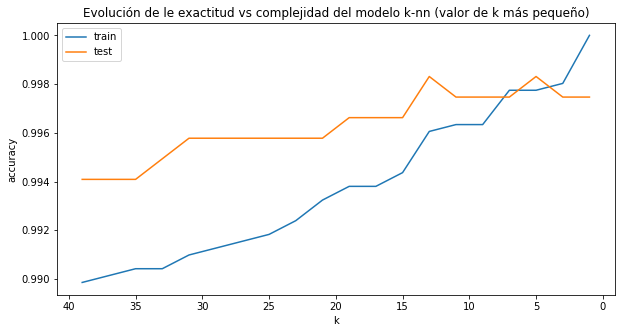

In [541]:
plt.figure(figsize=(10,5))
ax = plt.gca()
plt.plot(k_vec, vec_train)
plt.plot(k_vec, vec_test)
ax.set_xlim(ax.get_xlim()[::-1])
plt.axis('tight')
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('Evolución de le exactitud vs complejidad del modelo k-nn (valor de k más pequeño)')
plt.legend(['train', 'test'])

Seleccionar el mejor k modelo y sacar las metricas

### Cross_Val_Score

In [543]:
knn = neighbors.KNeighborsClassifier(n_neighbors=11)
exactitud = cross_val_score(knn, X_cod, y_cod, cv = 10, scoring='accuracy')
exactitud

array([0.9978903, 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       ])

In [544]:
print("Exactitudes: %0.2f (+/- %0.2f)" % (exactitud.mean(), exactitud.std() * 2), exactitud.mean(), exactitud.std())

Exactitudes: 1.00 (+/- 0.00) 0.9997890295358649 0.0006329113924050555


In [552]:
data_no_ident = pd.read_csv('Data_No_Identificada_Tratada.csv', sep=',')

In [553]:
preprocessor = ColumnTransformer(
    transformers=[
            ('numeric', numeric_transformer, data_num_c)],remainder='passthrough'
                )

In [557]:
data_scaler2 = data_no_ident[data_num_c]

In [558]:
preprocessor.fit_transform(data_scaler2)
datos_transf2 = preprocessor.transform(data_scaler2)
datos_transf2 = pd.DataFrame(datos_transf2, columns=data_scaler2.columns)
datos_transf2 = pd.concat([datos_transf2, data_no_ident[data_obje_c]],axis=1)

In [561]:
X2 = datos_transf2[data_num_c]
y2 = datos_transf2['Type']

In [562]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2,stratify=y2)

In [563]:
k_vec = np.arange(1,40,2)
k_vec

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39])

In [565]:
temp = y_test2[0:1184]

In [573]:
vec_train_2 = []
vec_test_2 =[]

for k in  k_vec:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_train)
    vec_train_2.append(metrics.accuracy_score(y_train, y_pred))
    y_pred = knn.predict(X_test)
    vec_test_2.append(metrics.accuracy_score(temp, y_pred))
v = pd.DataFrame()
v['k'] = k_vec
v['vec_train'] = vec_train_2
v['vec_test'] = vec_test_2
display(v)

,k,vec_train,vec_test
0,1,1.000000,0.477196
1,3,0.998028,0.477196
2,5,0.997746,0.476351
3,7,0.997746,0.477196
4,9,0.996337,0.477196
5,11,0.996337,0.477196
6,13,0.996055,0.476351
7,15,0.994365,0.478041
8,17,0.993801,0.478041
9,19,0.993801,0.478041


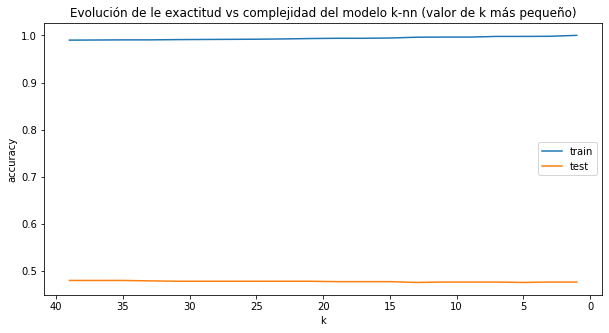

In [574]:
plt.figure(figsize=(10,5))
ax = plt.gca()
plt.plot(k_vec, vec_train_2)
plt.plot(k_vec, vec_test_2)
ax.set_xlim(ax.get_xlim()[::-1])
plt.axis('tight')
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('Evolución de le exactitud vs complejidad del modelo k-nn (valor de k más pequeño)')
plt.legend(['train', 'test'])

knn = neighbors.KNeighborsClassifier(n_neighbors=3)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
acc_test_vec=[]
for indices_train, indices_test in kf.split(X_cod, y_cod):
    knn.fit(X_cod[indices_train], y_cod[indices_train])
    y_pred = knn.predict(X_cod[indices_test])
    acc_test_vec.append(metrics.accuracy_score(y_cod[indices_test], y_pred))  
acc_test_vec

https://www.analyticslane.com/2018/07/02/gridsearchcv/#:~:text=GridSearchCV%20es%20una%20clase%20disponible,los%20par%C3%A1metros%20de%20un%20modelo.&text=En%20caso%20de%20que%20se,aleatorios%20existe%20el%20m%C3%A9todo%20RandomizedSearchCV.